# Payment Fraud Detection — EDA, Feature Engineering, Modeling & Evaluation

**Notebook purpose:** run an end-to-end pipeline that:
- loads the ULB/Kaggle credit card fraud dataset (`/kaggle/input/creditcardfraud/creditcard.csv`),
- reproduces EDA findings,
- creates features informed by EDA (log amount, zero-amount indicator, time-based deltas),
- trains classifiers (Logistic Regression, Decision Tree) with proper label handling,
- performs hyperparameter tuning,
- evaluates and visualizes train/test results (confusion matrices, ROC, PR, feature importances),
- saves key figures and outputs.

**Notes:** this notebook expects the dataset path `/kaggle/input/creditcardfraud/creditcard.csv` to be available (Kaggle runtime). If you run locally, update the `DATA_PATH` variable accordingly.


In [38]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

sns.set(style='whitegrid')
%matplotlib inline

DATA_PATH = '/kaggle/input/creditcardfraud/creditcard.csv'  # change for local usage s
print('Notebook prepared. Data path =', DATA_PATH)


Notebook prepared. Data path = /kaggle/input/creditcardfraud/creditcard.csv


In [39]:
# Load dataset
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please change DATA_PATH to the correct location.")

df = pd.read_csv(DATA_PATH)
print('Loaded', df.shape, 'data')

df.head()


Loaded (284807, 31) data


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Amount statistics:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


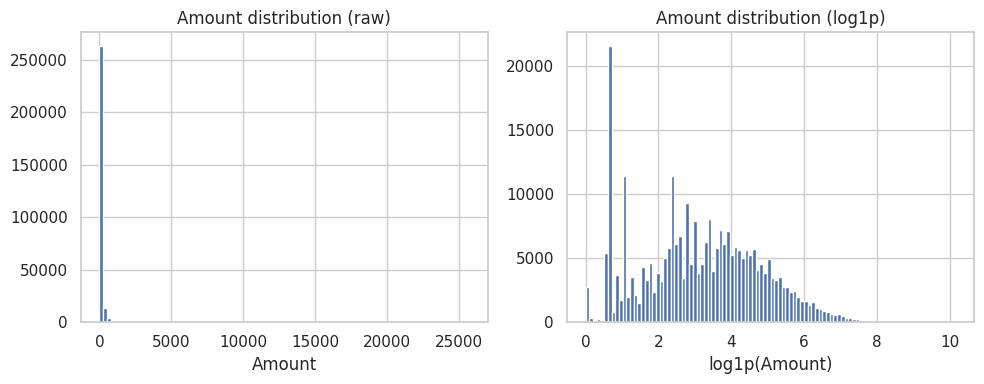

In [40]:
# Class balance
print('Class distribution:')
print(df['Class'].value_counts(normalize=True))

print('\nAmount statistics:')
print(df['Amount'].describe())

# Histogram of Amount (log scale) and class imbalance
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['Amount'], bins=100); plt.title('Amount distribution (raw)'); plt.xlabel('Amount')
plt.subplot(1,2,2)
plt.hist(np.log1p(df['Amount']), bins=100); plt.title('Amount distribution (log1p)'); plt.xlabel('log1p(Amount)')
plt.tight_layout()
plt.show()


In [1]:
# High correlate features
sns.scatterplot(x=df['V13'], y=df['V10'], hue=df['Class'])

NameError: name 'sns' is not defined

In [42]:
# Feature engineering guided by EDA

df = df.sort_values('Time').reset_index(drop=True)

# zero amount indicator 
# df['is_zero_amount'] = (df['Amount'] == 0).astype(int)
# log amount 
df['log_amount'] = np.log1p(df['Amount'])

print('Feature engineering completed. New columns:', [c for c in df.columns if c not in ['Time','Amount','Class']][:20])


Feature engineering completed. New columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']


In [43]:
# Prepare features and target
feature_cols = [c for c in df.columns if (c.startswith('V') or c in ['log_amount','is_zero_amount'])]

X = df[feature_cols].fillna(0)
y = df['Class']

print('Feature matrix shape:', X.shape)


Feature matrix shape: (284807, 30)


In [2]:
# more feature engineering
# high correlate 
#for col in ['V14','V10','V12','V17']:
#    X[f'{col}_low'] = (X[col] < -5).astype(int)

In [45]:
# more feature enginering
# new feature
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
X[['V14','V10','V12','V17']] = rs.fit_transform(X[['V14','V10','V12','V17']])
X['anomaly_score'] = X[['V14','V10','V12','V17']].mean(axis=1)


In [46]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)
print('Train class distribution:\n', y_train.value_counts(normalize=True))


Train: (227845, 31) Test: (56962, 31)
Train class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64


In [47]:
# Define pipelines
pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(class_weight= {0: 1, 1: 5}, solver='liblinear', max_iter=1000))])
pipe_dt = Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier(class_weight= {0: 1, 1: 5}, random_state=42))])

models = {'LogisticRegression': pipe_lr, 'DecisionTree': pipe_dt}


In [48]:
# Hyperparameter grids
param_grids = {
    'LogisticRegression': {'clf__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
    'DecisionTree': {'clf__criterion': ['gini','entropy'], 'clf__max_depth': [3,5,8,12], 'clf__min_samples_leaf':[10,30,50]}
}

best_models = {}
for name, pipeline in models.items():
    print('\nTraining', name)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='average_precision', n_jobs=-1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best_models[name] = grid.best_estimator_
    
print('\nTraining completed')



Training LogisticRegression
Best params: {'clf__C': 0.05}

Training DecisionTree
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 10}

Training completed



=== Model: LogisticRegression ===

-- Train classification report --
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996    227451
           1     0.8906    0.5990    0.7162       394

    accuracy                         0.9992    227845
   macro avg     0.9449    0.7994    0.8579    227845
weighted avg     0.9991    0.9992    0.9991    227845


-- Test classification report --
              precision    recall  f1-score   support

           0     0.9993    0.9999    0.9996     56864
           1     0.8806    0.6020    0.7152        98

    accuracy                         0.9992     56962
   macro avg     0.9400    0.8010    0.8574     56962
weighted avg     0.9991    0.9992    0.9991     56962



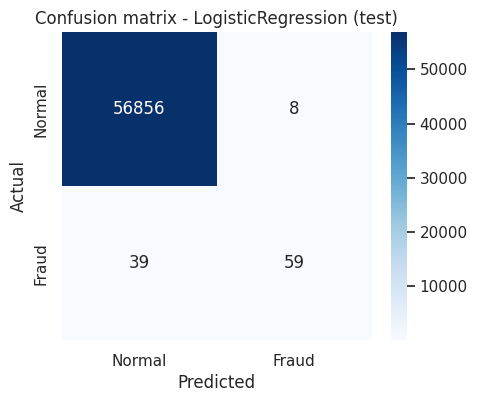

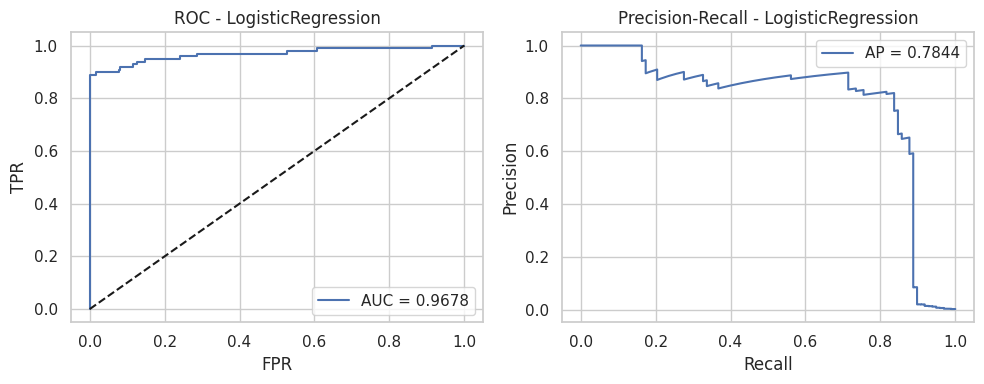


=== Model: DecisionTree ===

-- Train classification report --
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998    227451
           1     0.9401    0.7970    0.8626       394

    accuracy                         0.9996    227845
   macro avg     0.9699    0.8984    0.9312    227845
weighted avg     0.9995    0.9996    0.9995    227845


-- Test classification report --
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8929    0.7653    0.8242        98

    accuracy                         0.9994     56962
   macro avg     0.9462    0.8826    0.9119     56962
weighted avg     0.9994    0.9994    0.9994     56962



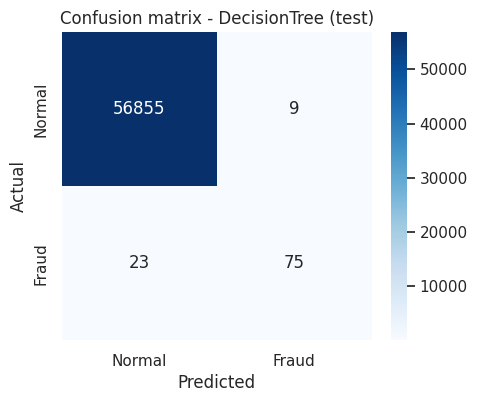

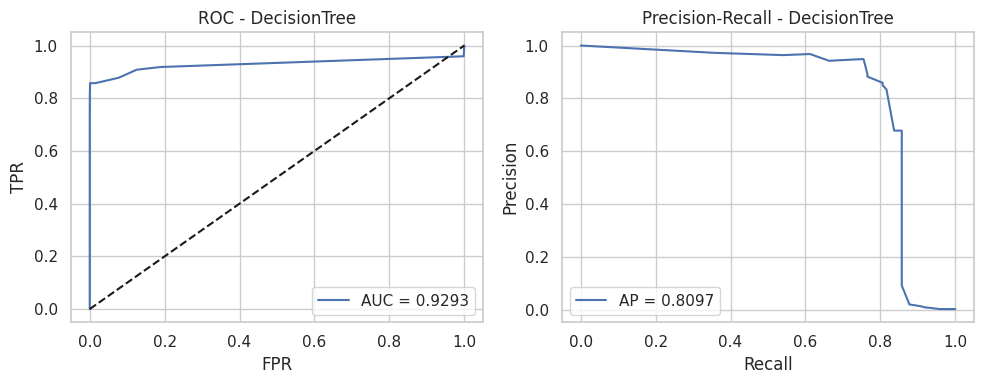

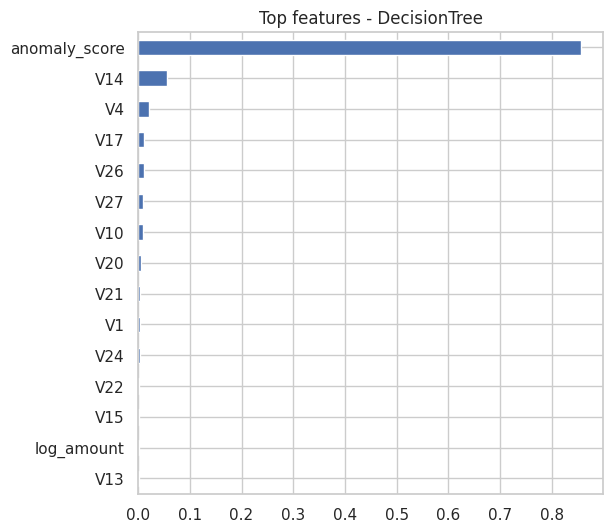

In [49]:
# Evaluation 
import itertools

def plot_confusion(cm, labels, title='Confusion matrix', figsize=(5,4)):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

for name, model in best_models.items():
    print('\n=== Model:', name, '===')
    # Train performance
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:,1]
    print('\n-- Train classification report --')
    print(classification_report(y_train, y_train_pred, digits=4))
    
    # Test performance
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:,1]
    print('\n-- Test classification report --')
    print(classification_report(y_test, y_test_pred, digits=4))

    # Confusion matrices
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion(cm_test, labels=['Normal','Fraud'], title=f'Confusion matrix - {name} (test)')

    # ROC & PR
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    ap = average_precision_score(y_test, y_test_proba)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {name}'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'AP = {ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'Precision-Recall - {name}'); plt.legend()
    plt.tight_layout(); plt.show()

    # Feature importance if available
    if name == 'DecisionTree':
        feat_imp = pd.Series(model.named_steps['clf'].feature_importances_, index=X.columns)
        top = feat_imp.sort_values(ascending=False).head(15)
        plt.figure(figsize=(6,6))
        top.plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title(f'Top features - {name}')
        plt.show()


In [50]:
# Save models 
import joblib
os.makedirs('/mnt/data/fraud_models', exist_ok=True)
for name, model in best_models.items():
    path = f'/mnt/data/fraud_models/{name}.joblib'
    joblib.dump(model, path)
    print('Saved', path)

# Save a CSV with test predictions
pred_df = X_test.copy()
pred_df['y_true'] = y_test
for name, model in best_models.items():
    pred_df[f'{name}_proba'] = model.predict_proba(X_test)[:,1]
    pred_df[f'{name}_pred'] = model.predict(X_test)

pred_df[['y_true'] + [c for c in pred_df.columns if 'proba' in c or '_pred' in c]].head().to_csv('/mnt/data/fraud_models/test_predictions_preview.csv', index=False)
print('Saved test predictions preview to /mnt/data/fraud_models/test_predictions_preview.csv')


Saved /mnt/data/fraud_models/LogisticRegression.joblib
Saved /mnt/data/fraud_models/DecisionTree.joblib
Saved test predictions preview to /mnt/data/fraud_models/test_predictions_preview.csv


---

**Notebook saved.**

This notebook performs EDA-driven feature engineering, trains two classifiers with proper label handling and stratified splits, and evaluates them with robust metrics (confusion matrix, ROC, PR, AP). It also saves trained models and a preview of test predictions to `/mnt/data/fraud_models/`.

**How to run:**
1. Upload this notebook to a Kaggle kernel or run locally after updating `DATA_PATH`.
2. Execute cells top-to-bottom. The notebook will produce plots and saved artifacts.

**Files saved by the notebook (when executed):**
- `/mnt/data/fraud_models/LogisticRegression.joblib`
- `/mnt/data/fraud_models/DecisionTree.joblib`
- `/mnt/data/fraud_models/test_predictions_preview.csv`
